In [1]:
import numpy as np
import os
import sys
import time
import pandas as pd 

import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
data = pd.read_csv('C:/Users/vivek/Desktop/Stock-Price-Prediction-master/ge.us.txt')

In [3]:
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14058 entries, 0 to 14057
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     14058 non-null  object 
 1   Open     14058 non-null  float64
 2   High     14058 non-null  float64
 3   Low      14058 non-null  float64
 4   Close    14058 non-null  float64
 5   Volume   14058 non-null  int64  
 6   OpenInt  14058 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 768.9+ KB


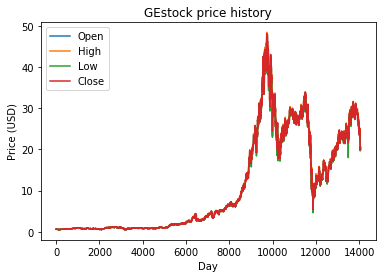

In [5]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(data["Open"])
plt.plot(data["High"])
plt.plot(data["Low"])
plt.plot(data["Close"])
plt.title('GEstock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Day')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()


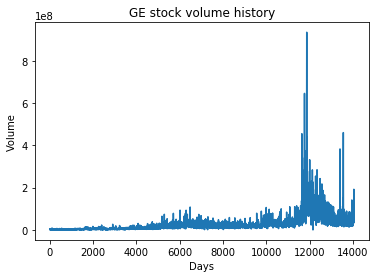

In [6]:
plt.figure()
plt.plot(data["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [7]:
print("checking if any null values are present\n", data.isna().sum())

checking if any null values are present
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 11246 2812


In [9]:
TIME_STEPS = 60
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in (range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [10]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [11]:
BATCH_SIZE = 20
lr=0.00010000
OUTPUT_PATH = 'C:/Users/vivek/Desktop/Stock-Price-Prediction-master'
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (11186, 60, 5) (11186,)
length of time-series i/o (2752, 60, 5) (2752,)


In [12]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [13]:
from keras.models import load_model
lstm_model = load_model('model.h5')

In [14]:
# csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'v' + '.log'), append=True)

# history = lstm_model.fit(x_t, y_t, epochs=20, verbose=1, batch_size=BATCH_SIZE,
#                     shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
#                     trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

Train on 11180 samples, validate on 1360 samples
Epoch 1/20
11180/11180 [==============================] - 56s 5ms/step - loss: 6.9159e-04 - val_loss: 0.0016
Epoch 2/20
11180/11180 [==============================] - 56s 5ms/step - loss: 7.0112e-04 - val_loss: 0.0015
Epoch 3/20
11180/11180 [==============================] - 56s 5ms/step - loss: 6.6963e-04 - val_loss: 0.0014
Epoch 4/20
11180/11180 [==============================] - 56s 5ms/step - loss: 6.2427e-04 - val_loss: 0.0013
Epoch 5/20
11180/11180 [==============================] - 44s 4ms/step - loss: 6.3330e-04 - val_loss: 0.0016
Epoch 6/20
11180/11180 [==============================] - 18s 2ms/step - loss: 6.3863e-04 - val_loss: 0.0014
Epoch 7/20
11180/11180 [==============================] - 17s 2ms/step - loss: 6.0583e-04 - val_loss: 0.0013
Epoch 8/20
11180/11180 [==============================] - 18s 2ms/step - loss: 5.7573e-04 - val_loss: 0.0013
Epoch 9/20
11180/11180 [==============================] - 17s 2ms/step - loss: 

In [15]:
pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE),batch_size=BATCH_SIZE)

In [16]:
real = y_test_t

In [17]:
  lstm_model.save('model.h5')

In [18]:
lstm_model.save_weights('weights_lstm')

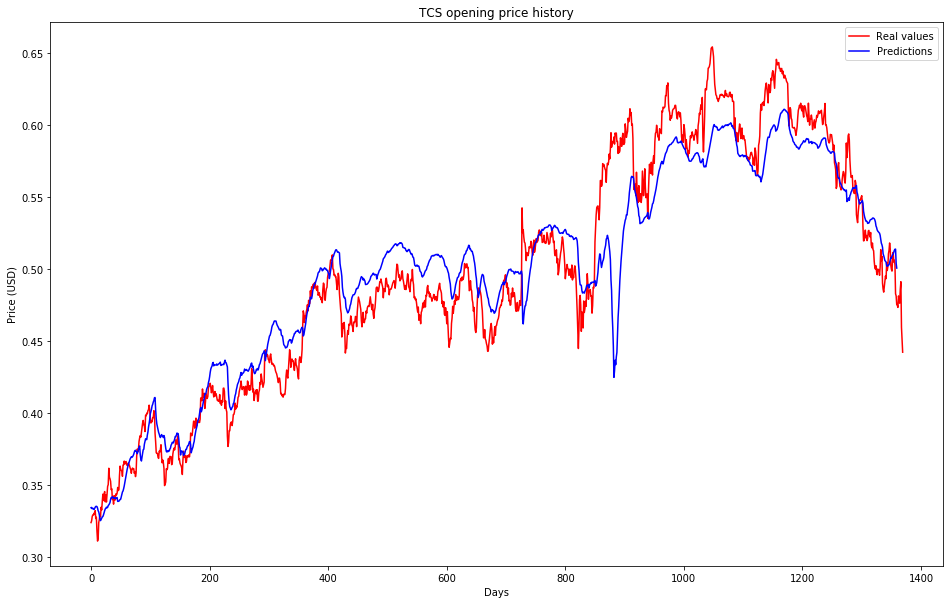

In [21]:
plt.figure(figsize=(16,10))
plt.plot(real, 'r')
plt.plot(pred, 'b')
plt.title('Google Stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(["Real values", "Predictions"], loc='upper right')
plt.show()

2